In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw = pd.read_excel("./../Normalized_table.xlsx")
wordFeaturesRaw = pd.read_excel("./../xk/excel/feature.xlsx")
wordFeaturesColumns = ['Replication number','Frequency','characters','root']
dateNum= (pd.to_numeric(pd.to_datetime(raw['Date']))/(3600*24*1e9)).astype(int)

featuresColumns = "Date  Replication number  Frequency  characters  root".split('  ')
labelsColumns = ['Means','Stddev']
dataSet = pd.concat([raw.loc[:, 'Word'], dateNum,wordFeaturesRaw.loc[:, wordFeaturesColumns], raw[['Means','Stddev']]], axis=1)

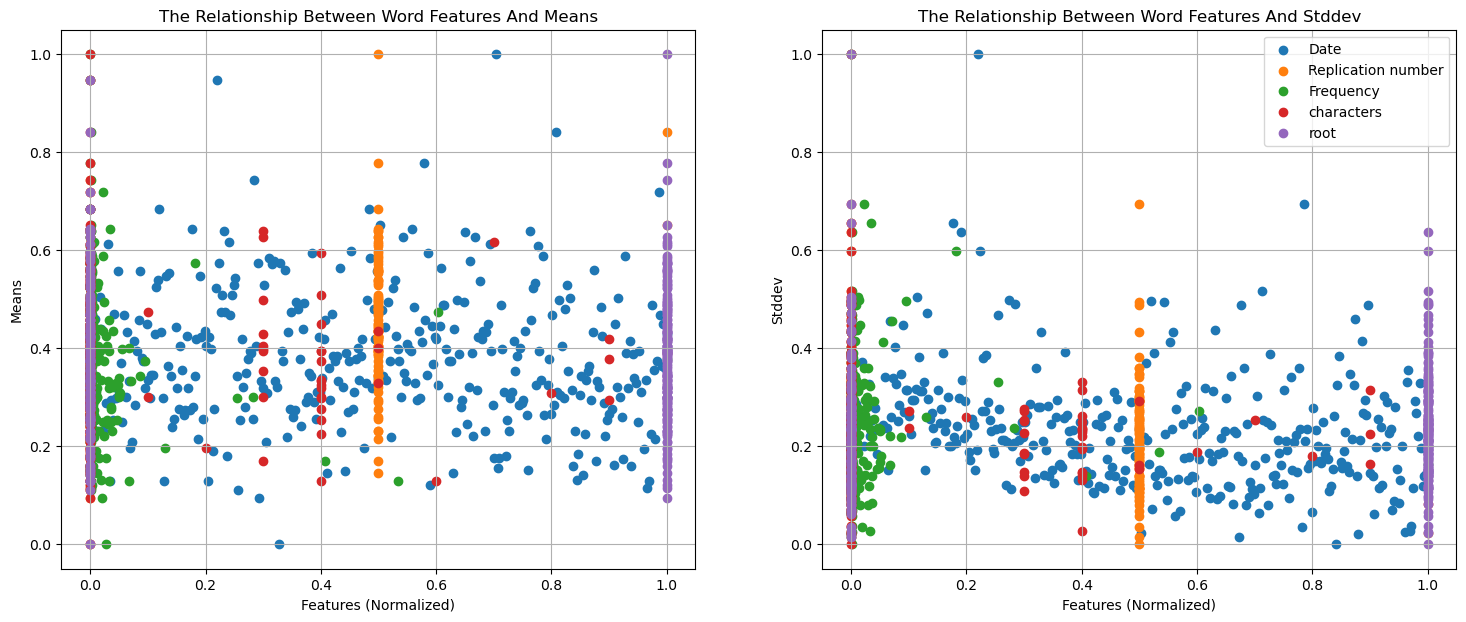

In [3]:
fig,axs=plt.subplots(1,len(labelsColumns),figsize=(18,7))
showData = (dataSet.iloc[:,1:].copy()-dataSet.iloc[:,1:].min())/(dataSet.iloc[:,1:].max()-dataSet.iloc[:,1:].min())
# showData['Frequency'] = (showData['Frequency']-showData['Frequency'].mean())/showData['Frequency'].std()

for axn in range(len(axs)):
    for feature in featuresColumns:
        sorted = showData.sort_values(feature)
        axs[axn].grid(True)
        axs[axn].scatter(sorted[feature], sorted[labelsColumns[axn]], label=feature, marker='o')
        axs[axn].set_xlabel("Features (Normalized)")
        axs[axn].set_ylabel(labelsColumns[axn])
        axs[axn].set_title(f"The Relationship Between Word Features And {labelsColumns[axn]}")

axs[1].legend()
plt.show(fig)

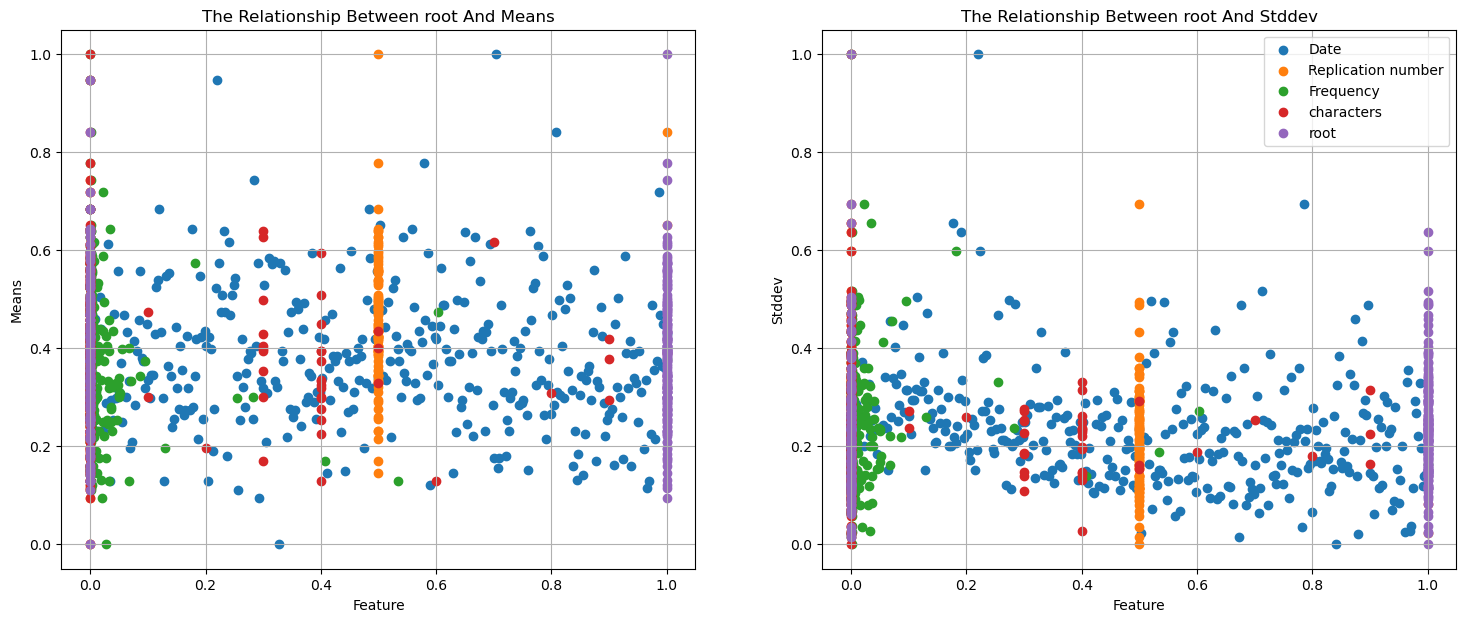

In [4]:
showData = (dataSet.iloc[:,1:].copy()-dataSet.iloc[:,1:].min())/(dataSet.iloc[:,1:].max()-dataSet.iloc[:,1:].min())
# showData['Frequency'] = (showData['Frequency']-showData['Frequency'].mean())/showData['Frequency'].std()

def ShowScatter(dataVec:pd.DataFrame,xCols:list, yCols:list, norm1=False, norm2=False):
    fig,axs=plt.subplots(1,len(yCols),figsize=(18,7))
    for xCol in xCols:
        sorted = dataVec.sort_values(xCol)
        for axn in range(len(axs)):
            axs[axn].grid(True)
            axs[axn].scatter(sorted[xCol], sorted[yCols[axn]], label=xCol, marker='o')
            axs[axn].set_xlabel(f"Feature")
            axs[axn].set_ylabel(labelsColumns[axn])
            axs[axn].set_title(f"The Relationship Between {xCol} And {yCols[axn]}")

    axs[len(yCols)-1].legend()
    plt.show(fig)

showCol = 'characters'
ShowScatter(showData[featuresColumns+labelsColumns], featuresColumns, labelsColumns)

In [5]:
"""这数据属实千奇百怪，有些聚合很高，用PCA搞一下"""
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

def NormalizeData(data:pd.DataFrame)->pd.DataFrame:
    std=StandardScaler().fit_transform(data)
    nm=MinMaxScaler().fit_transform(std)
    return nm

norm = NormalizeData(dataSet.loc[:,featuresColumns])
pca=PCA()
pcaData = pd.DataFrame(pca.fit_transform(norm))
print(pca.explained_variance_ratio_.cumsum())
pcaData

[0.60164757 0.80152166 0.93046119 0.98889229 1.        ]


,0,1,2,3,4
0,0.514589,0.501073,-0.114059,-0.024271,-0.016192
1,-0.484506,0.517262,-0.086466,-0.052267,-0.019718
2,0.527659,0.451742,0.383330,-0.029735,-0.015075
3,-0.484664,0.511813,-0.086948,-0.051241,-0.014509
4,0.514064,0.490727,-0.114997,-0.016620,0.019026
...,...,...,...,...,...
350,-0.491877,-0.507993,0.325397,-0.077983,0.007990
351,-0.505126,-0.466994,-0.172723,-0.072602,0.007499
352,0.493866,-0.488781,-0.200805,-0.045107,0.009471
353,-0.505233,-0.472579,-0.173211,-0.072967,0.006546


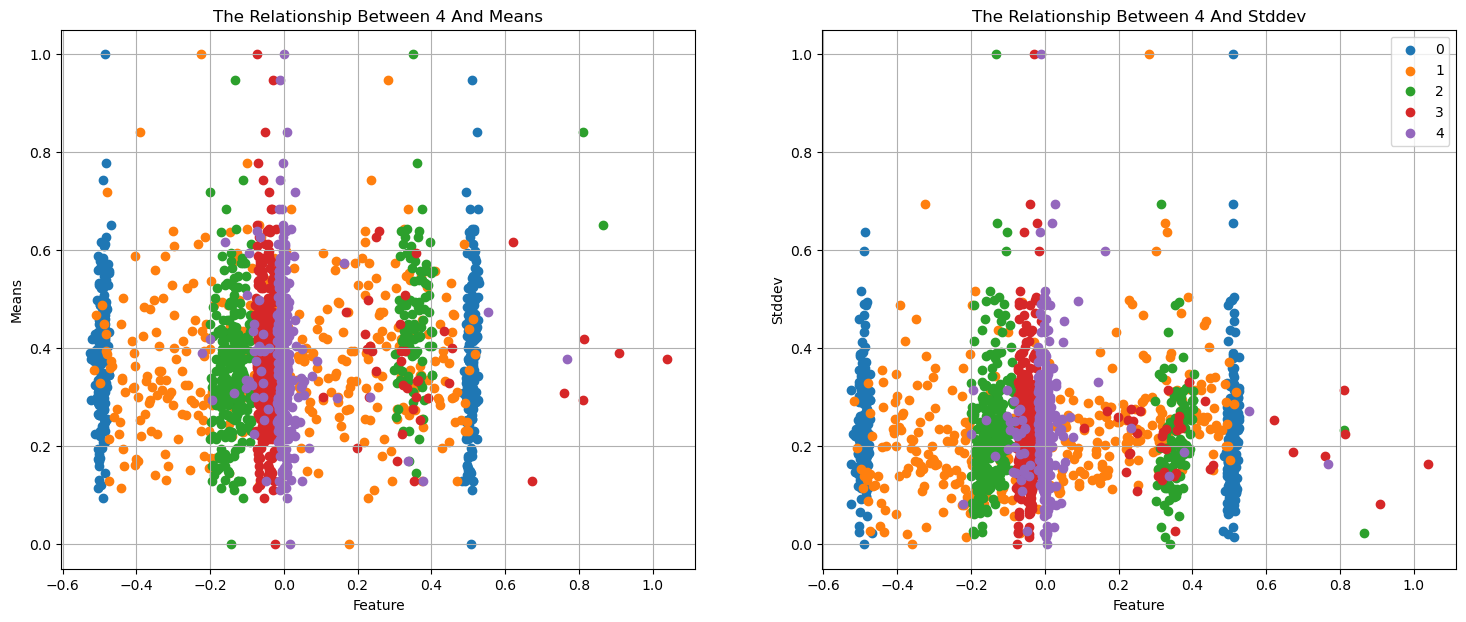

In [6]:
# pd.concat([pcaData,showData], axis=1)
ShowScatter(pd.concat([pcaData,showData], axis=1), [0,1,2,3,4], labelsColumns)

In [7]:
"""划分数据集"""
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

allDataSet = pd.concat([pcaData, dataSet.loc[:, labelsColumns]],axis=1)
train,test = train_test_split(allDataSet, test_size=0.2)
train,validate=train_test_split(train, test_size=0.2)

MSE:
 Means     0.163467
Stddev    0.006092
dtype: float64
MAE:
 Means     0.315788
Stddev    0.064234
dtype: float64


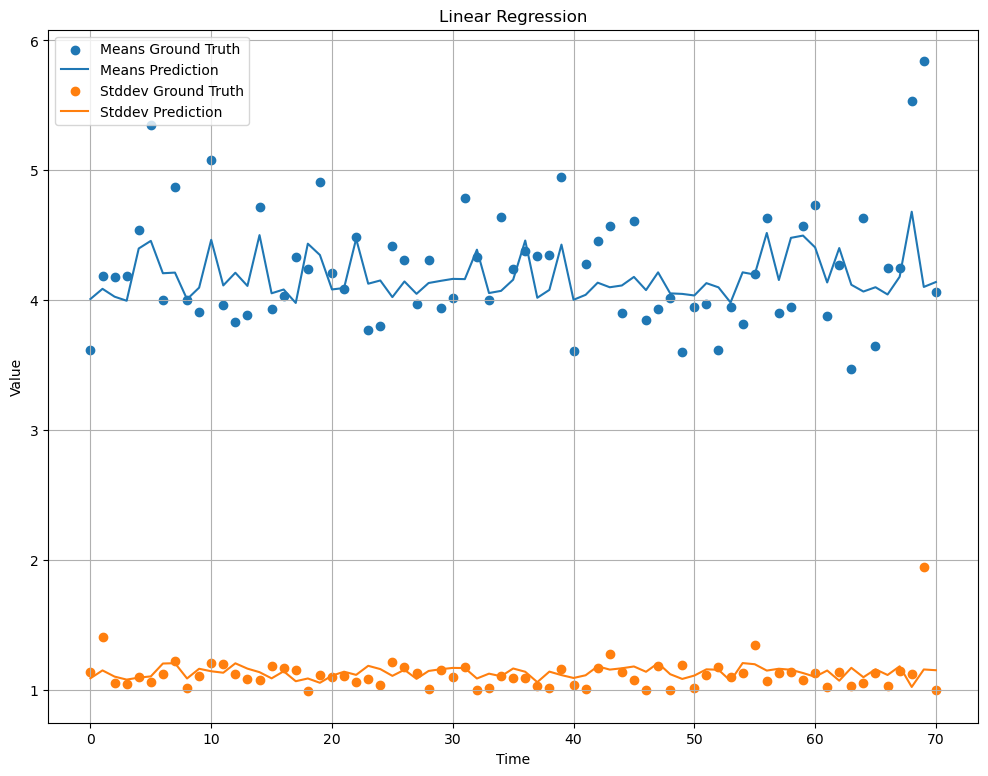

In [43]:
assert isinstance(allDataSet, pd.DataFrame)
assert isinstance(train, pd.DataFrame)
assert isinstance(validate, pd.DataFrame)
assert isinstance(test, pd.DataFrame)

from sklearn.metrics import mean_squared_error

linearModel=LinearRegression(copy_X=True).fit(train.loc[:,:4], train.loc[:,labelsColumns])

def ModelAnalyse(test_x:pd.DataFrame,test_y:pd.DataFrame, model:LinearRegression):
    predict_y=pd.DataFrame(model.predict(test_x), columns=test_y.columns)
    print("MSE:\n",((predict_y-test_y)**2).mean())
    print("MAE:\n", ((predict_y-test_y).abs()).mean())

    fig,ax=plt.subplots(figsize=(12,9))
    for label in test_y.columns:
        ax.scatter(range(len(test_y)),test_y[label], label=label+" Ground Truth")
        ax.plot(range(len(test_y)),predict_y[label], label=label+" Prediction")
    ax.legend()
    ax.set_title("Linear Regression")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    return predict_y

prediction = ModelAnalyse(test.loc[:,:4], test.loc[:,labelsColumns], linearModel)

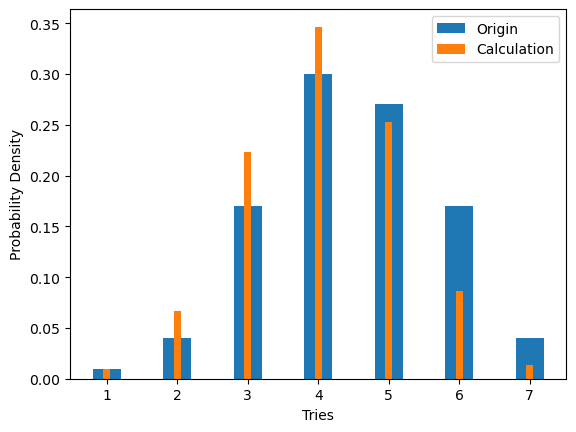

In [79]:
import scipy.stats as stats
import scipy.stats as stats
from scipy.integrate import quad

def normalize(mu:float,sigma:float, groundTruth:pd.DataFrame):
    # 正态分布的均值和标准差
    # 定义计算正态分布在指定区间内的概率密度的函数
    def integrand(x):
        return stats.norm.pdf(x, mu, sigma)

    # 要计算的多个区间

    intervals = [(0.5, 1.5), (1.5, 2.5), (2.5, 3.5), (3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]

    # 计算每个区间的概率密度
    probabilities = []
    for interval in intervals:
        p, _ = quad(integrand, interval[0], interval[1])
        probabilities.append(p)

    fig, ax = plt.subplots()
    ax.bar(range(1,len(intervals)+1), groundTruth/100,label='Origin', width=0.4)
    ax.bar(range(1,1+len(intervals)), probabilities, width=0.1, label='Calculation')
    
    ax.set_ylabel('Probability Density')
    ax.set_xlabel("Tries")
    ax.legend()
    plt.show()

for index in range(20, 21):
    normalize(prediction.loc[index, 'Means'], prediction.loc[index,'Stddev'], raw.loc[index,'1 try':'7 or more tries (X)'])

def ToDistribution(mu:float, sigma:float)->list:
    # 正态分布的均值和标准差
    # 定义计算正态分布在指定区间内的概率密度的函数
    def integrand(x):
        return stats.norm.pdf(x, mu, sigma)
    # 要计算的多个区间
    intervals = [(0.5, 1.5), (1.5, 2.5), (2.5, 3.5), (3.5, 4.5), (4.5, 5.5), (5.5, 6.5), (6.5, 7.5)]
    # 计算每个区间的概率密度
    probabilities = []
    for interval in intervals:
        p, _ = quad(integrand, interval[0], interval[1])
        probabilities.append(p)

    return probabilities


MSE:
 1 try                  0.000015
2 tries                0.001149
3 tries                0.009540
4 tries                0.002398
5 tries                0.005120
6 tries                0.004964
7 or more tries (X)    0.000572
dtype: float64
MAE:
 1 try                  0.002682
2 tries                0.025719
3 tries                0.082854
4 tries                0.033748
5 tries                0.059543
6 tries                0.050331
7 or more tries (X)    0.014797
dtype: float64


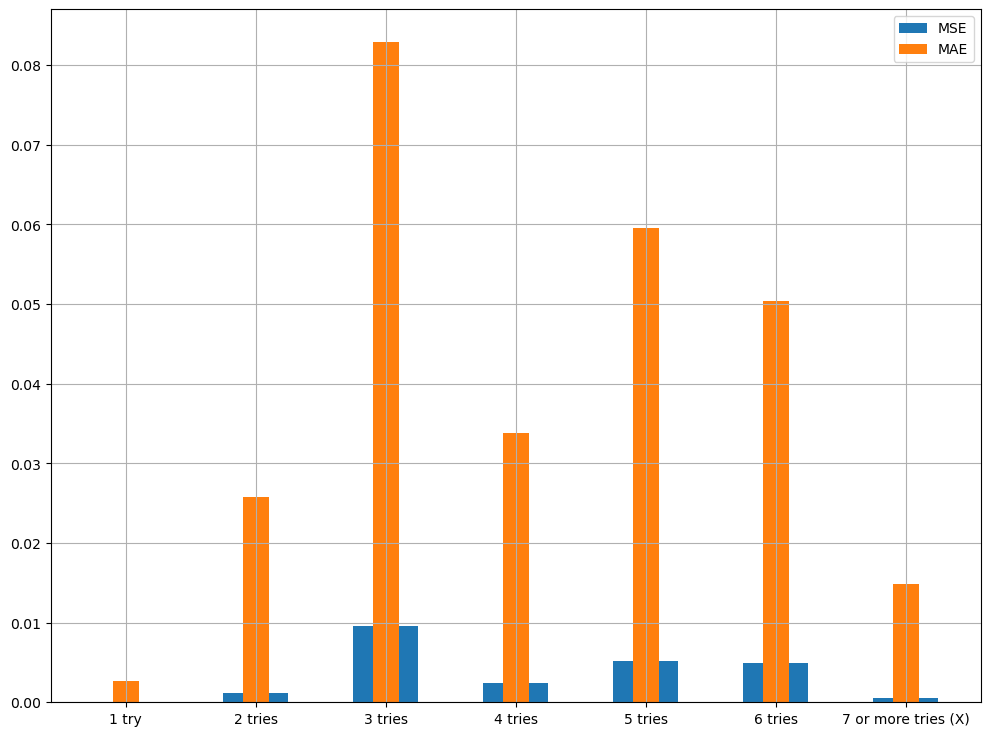

In [112]:
prediction_distribution=pd.DataFrame([
    ToDistribution(prediction.loc[x,'Means'],prediction.loc[x,'Stddev'])
    for x in prediction.index], 
    columns=
        raw.loc[:,'1 try':'7 or more tries (X)'].columns
)
groundTruth_distribution = raw.loc[test.index,'1 try':'7 or more tries (X)']/100

mse=((groundTruth_distribution-prediction_distribution)**2).mean()
mae=((groundTruth_distribution-prediction_distribution).abs()).mean()
print("MAE:\n",mae)
print("MSE:\n",mse)

fig,ax=plt.subplots(figsize=(12,9))
ax.bar(mse.index,mse, width=0.5, label='MSE')
ax.bar(mae.index,mae, width=0.2,label='MAE')
ax.legend()
ax.grid(True)